# 实验前的准备

导入相关的包

In [29]:
import os # 修改工作目录

import numpy as np
import pandas as pd
import scipy.stats as stats # 统计函数
import matplotlib.pyplot as plt
from plotnine import * # ggplot 绘图
from plotnine.data import mpg
from jupyterquiz import display_quiz # Quiz
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#from ggplot import ggplot

import math

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import f
from scipy.stats import t
from statsmodels.stats.stattools import durbin_watson

# 数据

数据集Project_1.csv是我们本次采集的数据，具体形式如下所示。

In [2]:
print('Project 1 is shown as follows: \n', pd.read_csv("Project_1.csv"))

Project 1 is shown as follows: 
     Obs  Chocolate  Capacity
0     1          1     118.8
1     2          1     122.6
2     3          1     115.6
3     4          1     113.6
4     5          1     119.5
5     6          1     115.9
6     7          1     115.8
7     8          1     115.1
8     9          1     116.9
9    10          1     115.4
10   11          1     115.6
11   12          1     107.9
12    1          2     105.4
13    2          2     101.1
14    3          2     102.7
15    4          2      97.1
16    5          2     101.9
17    6          2      98.9
18    7          2     100.0
19    8          2      99.8
20    9          2     102.6
21   10          2     100.9
22   11          2     104.5
23   12          2      93.5
24    1          3     102.1
25    2          3     105.8
26    3          3      99.6
27    4          3     102.7
28    5          3      98.8
29    6          3     100.9
30    7          3     102.8
31    8          3      98.7
32    9   

在Project_1这个数据集中共有36名志愿者的实验信息，包括编号，食用的巧克力类型以及一个小时后血浆的总抗氧能力

# 任务

在本次实验中，我们要解决以下七个问题：
- 两两比较 3 种巧克力对心血管健康的影响是否存在差异
- 判断 3 种巧克力对心血管健康的影响是否有差异
- 试说明所使用模型的合理性
- 估计食用这 3 种巧克力一小时后血浆的总抗氧能力。请分别给出点估计和区间估计
- 用Bonferroni方法比较吃了 3 种巧克力后，一个小时的血浆总抗氧能力两两是否存在差异
- 用Tukey方法比较吃了 3 种巧克力后，一个小时的血浆总抗氧能力两两是否存在差异。采用两种不同的方法来解决这个问题
- 基于这个例子，请评述一下Bonferroni方法和Tukey方法的异同

注：本实验中的显著性水平为 $\alpha = 0.05$。

# 解决方案

## 数据预处理

In [3]:
alpha = 0.05 # significant level
a = 3 # number of levels
m = 12 # number of replicates
n = a*m # sample size

- 响应变量

我们关心的是志愿者参与此次实验前后一个小时内的血浆总抗氧能力是否存在差异

In [4]:
## Load Data
Data = pd.read_csv("./Project_1.csv")
print(Data.columns)# Print the column names of Project_1

Index(['Obs', 'Chocolate', 'Capacity'], dtype='object')


In [9]:
## Construct a New Dataset
Data = Data.drop(labels=['Obs'], axis = 1) # delete the unrelated column from a dataset
print(Data)

   Chocolate  Capacity
0          1     118.8
1          1     122.6
2          1     115.6
3          1     113.6
4          1     119.5
5          1     115.9
6          1     115.8
7          1     115.1
8          1     116.9
9          1     115.4
10         1     115.6
11         1     107.9
12         2     105.4
13         2     101.1
14         2     102.7
15         2      97.1
16         2     101.9
17         2      98.9
18         2     100.0
19         2      99.8
20         2     102.6
21         2     100.9
22         2     104.5
23         2      93.5
24         3     102.1
25         3     105.8
26         3      99.6
27         3     102.7
28         3      98.8
29         3     100.9
30         3     102.8
31         3      98.7
32         3      94.7
33         3      97.8
34         3      99.7
35         3      98.6


这样我们构造了一个合适的数据集，其中包括两列的数据。第一列指的是每一名志愿者所被分配的巧克力类型，其取值分别为1，2 和 3。第二列指的是每一名志愿者经过1小时后血浆总抗氧能力的变化。

### Task1: 两两比较 3 种巧克力对心血管健康的影响是否存在差异

#### 类型1和类型2

In [10]:
Data["Chocolate"] = Data.Chocolate.astype(str) # 绘制ggplot
index_delete = Data[(Data["Chocolate"] == '3')].index.tolist()
Data12 = Data.drop(index = index_delete) # 比较类型1和类型2

print(Data12)

   Chocolate  Capacity
0          1     118.8
1          1     122.6
2          1     115.6
3          1     113.6
4          1     119.5
5          1     115.9
6          1     115.8
7          1     115.1
8          1     116.9
9          1     115.4
10         1     115.6
11         1     107.9
12         2     105.4
13         2     101.1
14         2     102.7
15         2      97.1
16         2     101.9
17         2      98.9
18         2     100.0
19         2      99.8
20         2     102.6
21         2     100.9
22         2     104.5
23         2      93.5


我们绘制一张图来刻画两种饮食方式下体重变化量的“分布”，如下图。

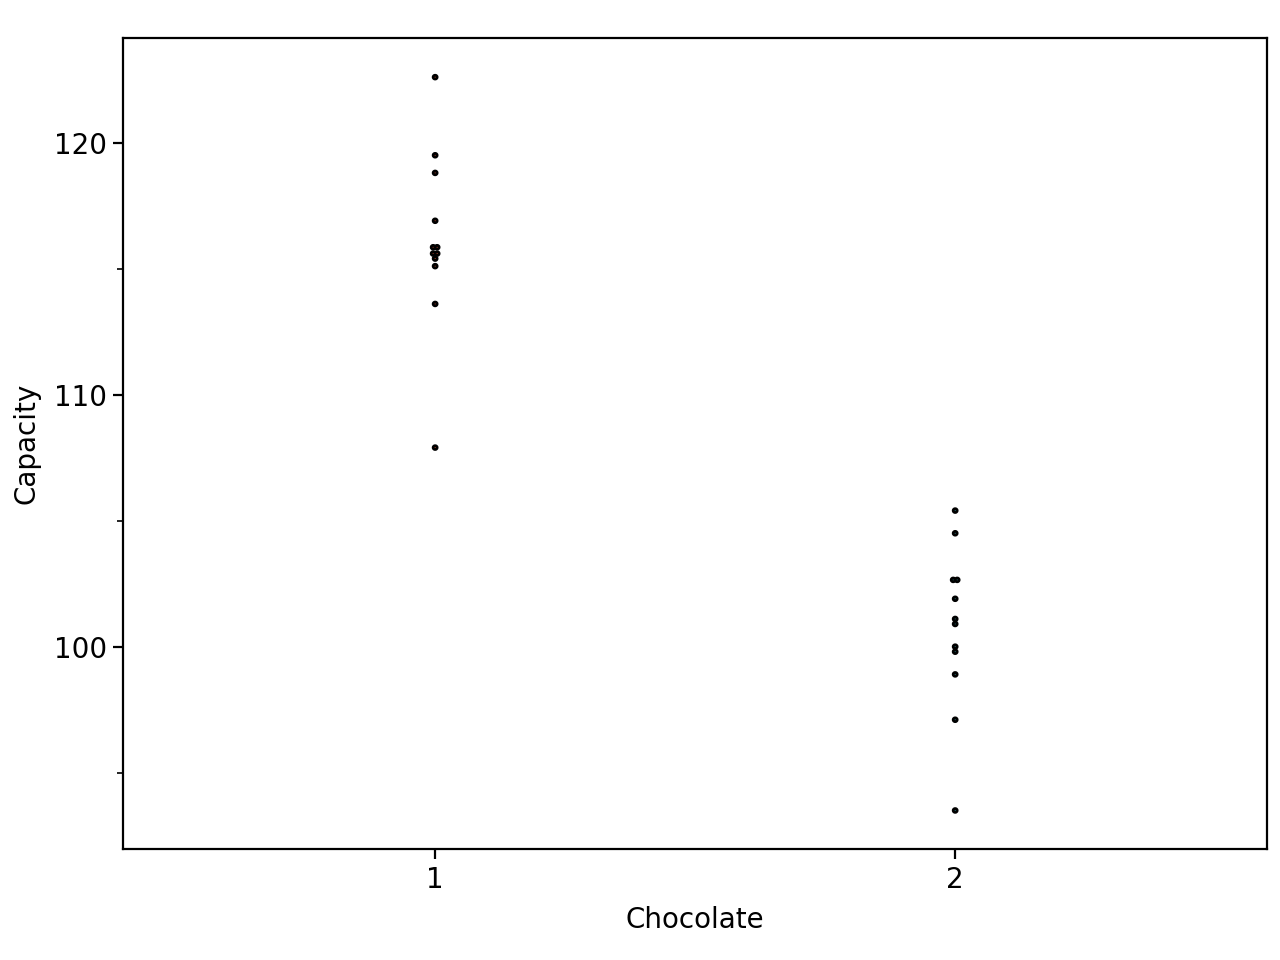

<Figure Size: (640 x 480)>

In [11]:
(ggplot(Data12, aes(x="Chocolate",y="Capacity",fill="Chocolate"))
         + geom_dotplot(binaxis = "y", stackdir = "center", binwidth = 0.15, show_legend = False)
         + scale_fill_hue(s = 0.90, l = 0.60, h = 0.05, color_space = 'husl')
         + theme_matplotlib())

使用t检验

In [12]:
# Reconstruct a dataset
Data12["Chocolate"] = Data.Chocolate.astype(int)
Data12_values = Data12.values
list_type = [1,2]
Group12_data = [Data12_values[Data12_values[:,0] == x,1] for x in list_type]
# Two-sample t test
t0,pVal0 = stats.ttest_ind(Group12_data[0],Group12_data[1])
print('得到的t值为: ', t0)
print('对应的p值为: ', end=' ')
print(pVal0)

得到的t值为:  11.10565260090929
对应的p值为:  1.7330939682091152e-10


可以得到p值小于显著性水平，所以拒绝原假设，即类型1和类型2的巧克力之间有明显差异

使用单因素方差分析

In [13]:
model = ols('Capacity~Chocolate', Data12).fit() # Add C() to numeric group indices
anovaResults = round(anova_lm(model),4)
print("\nThe ANOVA table: \n", anovaResults)


The ANOVA table: 
              df     sum_sq    mean_sq         F  PR(>F)
Chocolate   1.0  1415.2704  1415.2704  123.3355     0.0
Residual   22.0   252.4492    11.4750       NaN     NaN


得到p值为0，小于显著性水平，所以拒绝原假设，即类型1和类型2有明显差异

#### 类型1和类型3

In [14]:
Data["Chocolate"] = Data.Chocolate.astype(str)
index_delete = Data[(Data["Chocolate"] == '2')].index.tolist()
Data13 = Data.drop(index = index_delete)

print(Data13)

   Chocolate  Capacity
0          1     118.8
1          1     122.6
2          1     115.6
3          1     113.6
4          1     119.5
5          1     115.9
6          1     115.8
7          1     115.1
8          1     116.9
9          1     115.4
10         1     115.6
11         1     107.9
24         3     102.1
25         3     105.8
26         3      99.6
27         3     102.7
28         3      98.8
29         3     100.9
30         3     102.8
31         3      98.7
32         3      94.7
33         3      97.8
34         3      99.7
35         3      98.6


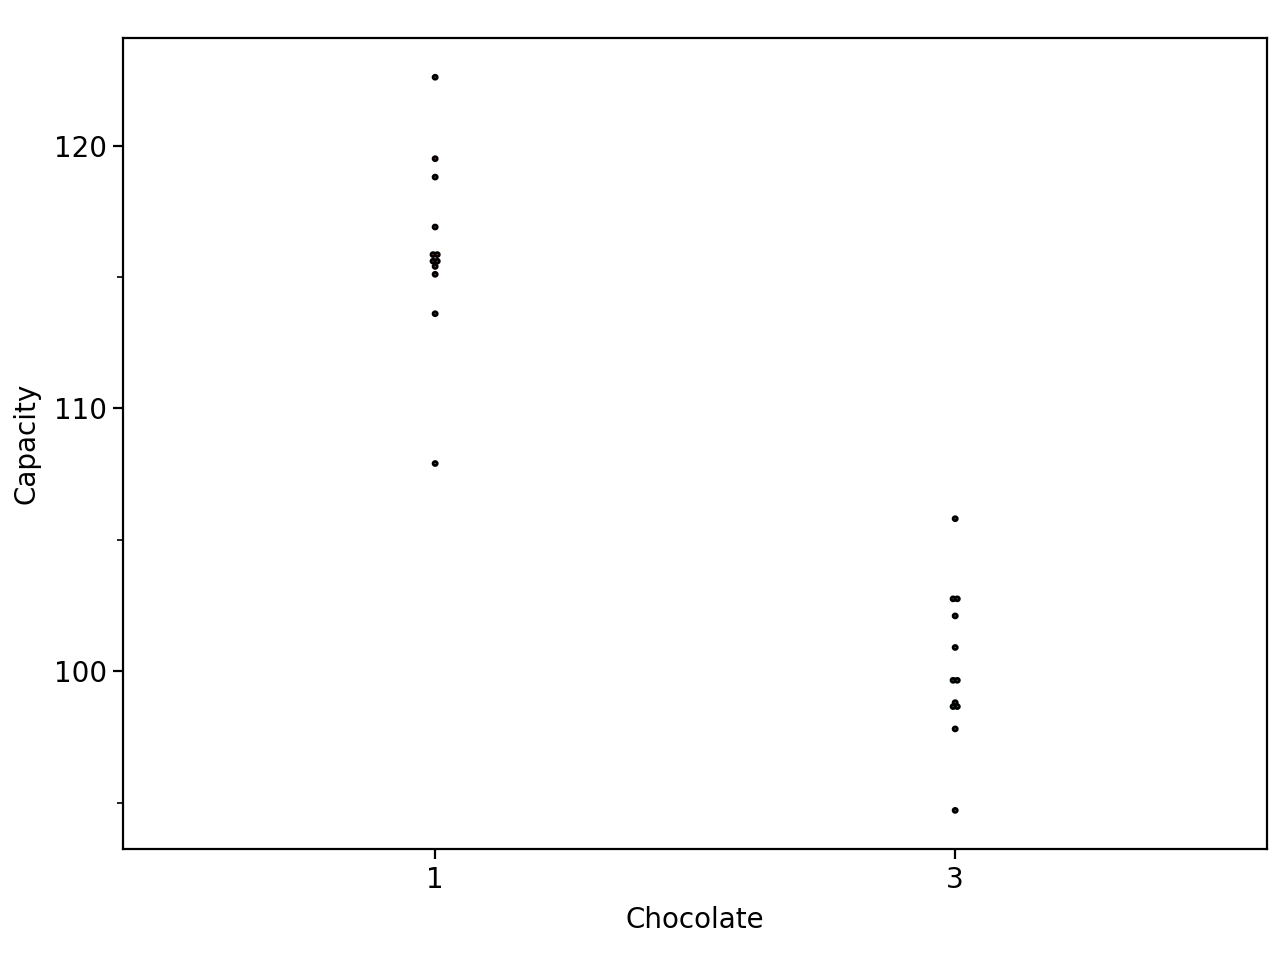

<Figure Size: (640 x 480)>

In [15]:
(ggplot(Data13, aes(x="Chocolate",y="Capacity",fill="Chocolate"))
         + geom_dotplot(binaxis = "y", stackdir = "center", binwidth = 0.15, show_legend = False)
         + scale_fill_hue(s = 0.90, l = 0.60, h = 0.05, color_space = 'husl')
         + theme_matplotlib())

使用t检验

In [16]:
# Reconstruct a dataset
Data13["Chocolate"] = Data13.Chocolate.astype(int)
Data13_values = Data13.values
list_type = [1,3]
Group13_data = [Data13_values[Data13_values[:,0] == x,1] for x in list_type]
# Two-sample t test
t0,pVal0 = stats.ttest_ind(Group13_data[0],Group13_data[1])
print('得到的t值为: ', t0)
print('得到的p值为: ', pVal0)

得到的t值为:  12.047774079768462
得到的p值为:  3.6833891525708707e-11


得到的p值小于显著性水平，所以拒绝原假设，即类型1和类型3的巧克力之间有明显差异

使用单因素方差分析

In [17]:
model = ols('Capacity~Chocolate', Data13).fit() # Add C() to numeric group indices
anovaResults = round(anova_lm(model),4)
print("\nThe ANOVA table: \n", anovaResults)


The ANOVA table: 
              df     sum_sq    mean_sq         F  PR(>F)
Chocolate   1.0  1512.0938  1512.0938  145.1489     0.0
Residual   22.0   229.1858    10.4175       NaN     NaN


得到p值小于显著性水平，拒绝原假设，即类型1和类型3巧克力有明显差异

#### 类型2和类型3

In [18]:
Data["Chocolate"] = Data.Chocolate.astype(str)
index_delete = Data[(Data["Chocolate"] == '1')].index.tolist()
Data23 = Data.drop(index = index_delete)

print(Data23)

   Chocolate  Capacity
12         2     105.4
13         2     101.1
14         2     102.7
15         2      97.1
16         2     101.9
17         2      98.9
18         2     100.0
19         2      99.8
20         2     102.6
21         2     100.9
22         2     104.5
23         2      93.5
24         3     102.1
25         3     105.8
26         3      99.6
27         3     102.7
28         3      98.8
29         3     100.9
30         3     102.8
31         3      98.7
32         3      94.7
33         3      97.8
34         3      99.7
35         3      98.6


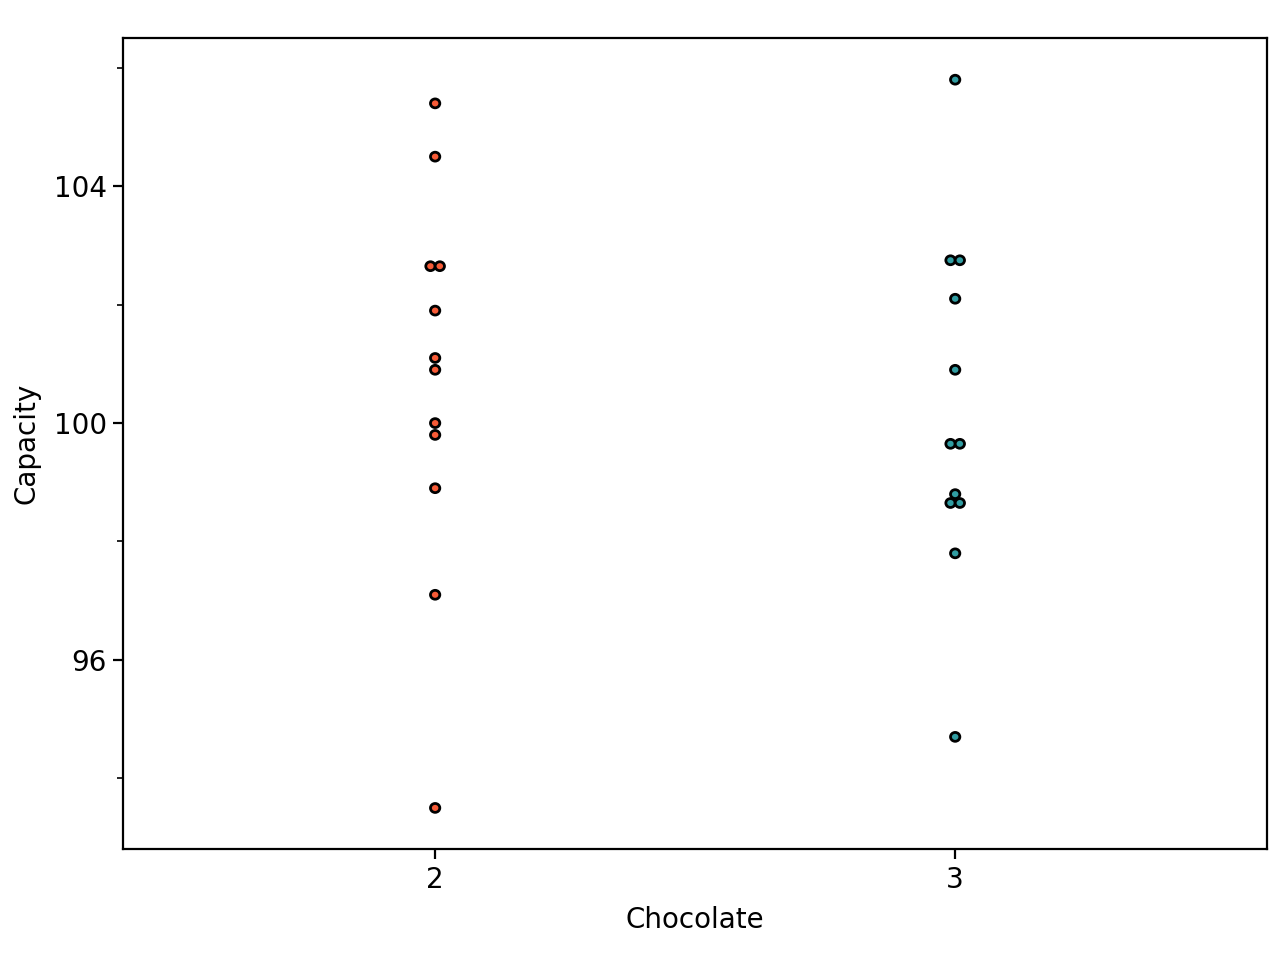

<Figure Size: (640 x 480)>

In [19]:
(ggplot(Data23, aes(x="Chocolate",y="Capacity",fill="Chocolate"))
         + geom_dotplot(binaxis = "y", stackdir = "center", binwidth = 0.15, show_legend = False)
         + scale_fill_hue(s = 0.90, l = 0.60, h = 0.05, color_space = 'husl')
         + theme_matplotlib())

使用t检验

In [20]:
# Reconstruct a dataset
Data23["Chocolate"] = Data23.Chocolate.astype(int)
Data23_values = Data23.values
list_type = [2,3]
Group23_data = [Data23_values[Data23_values[:,0] == x,1] for x in list_type]
# Two-sample t test
t0,pVal0 = stats.ttest_ind(Group23_data[0],Group23_data[1])
print('得到的t值为: ', t0)
print('得到的p值为: ', pVal0)

得到的t值为:  0.4126071170622644
得到的p值为:  0.6838877988482657


得到的p值大于显著性水平，所以接受原假设，即类型2和类型3的巧克力之间无显著差异

使用单因素方差分析

In [21]:
model = ols('Capacity~Chocolate', Data23).fit() # Add C() to numeric group indices
anovaResults = round(anova_lm(model),4)
print("\nThe ANOVA table: \n", anovaResults)


The ANOVA table: 
              df    sum_sq  mean_sq       F  PR(>F)
Chocolate   1.0    1.6017   1.6017  0.1702  0.6839
Residual   22.0  206.9767   9.4080     NaN     NaN


得到p值大于显著性水平，所以接受原假设，即类型2和类型3巧克力之间没有明显差异

### Task2: 判断 3 种巧克力对心血管健康的影响是否有差异

In [24]:
model = ols('Capacity~Chocolate', Data).fit() # Add C() to numeric group indices
anovaResults = round(anova_lm(model),4)
print("\nThe ANOVA table: \n", anovaResults)


The ANOVA table: 
              df     sum_sq   mean_sq        F  PR(>F)
Chocolate   2.0  1952.6439  976.3219  93.5756     0.0
Residual   33.0   344.3058   10.4335      NaN     NaN


p值小于显著性水平，所以拒绝原假设，即3种巧克力对心血管健康的影响无差异

### Task3: 试说明所使用模型的合理性

#### 独立性检验

Text(0, 0.5, 'Residuals')

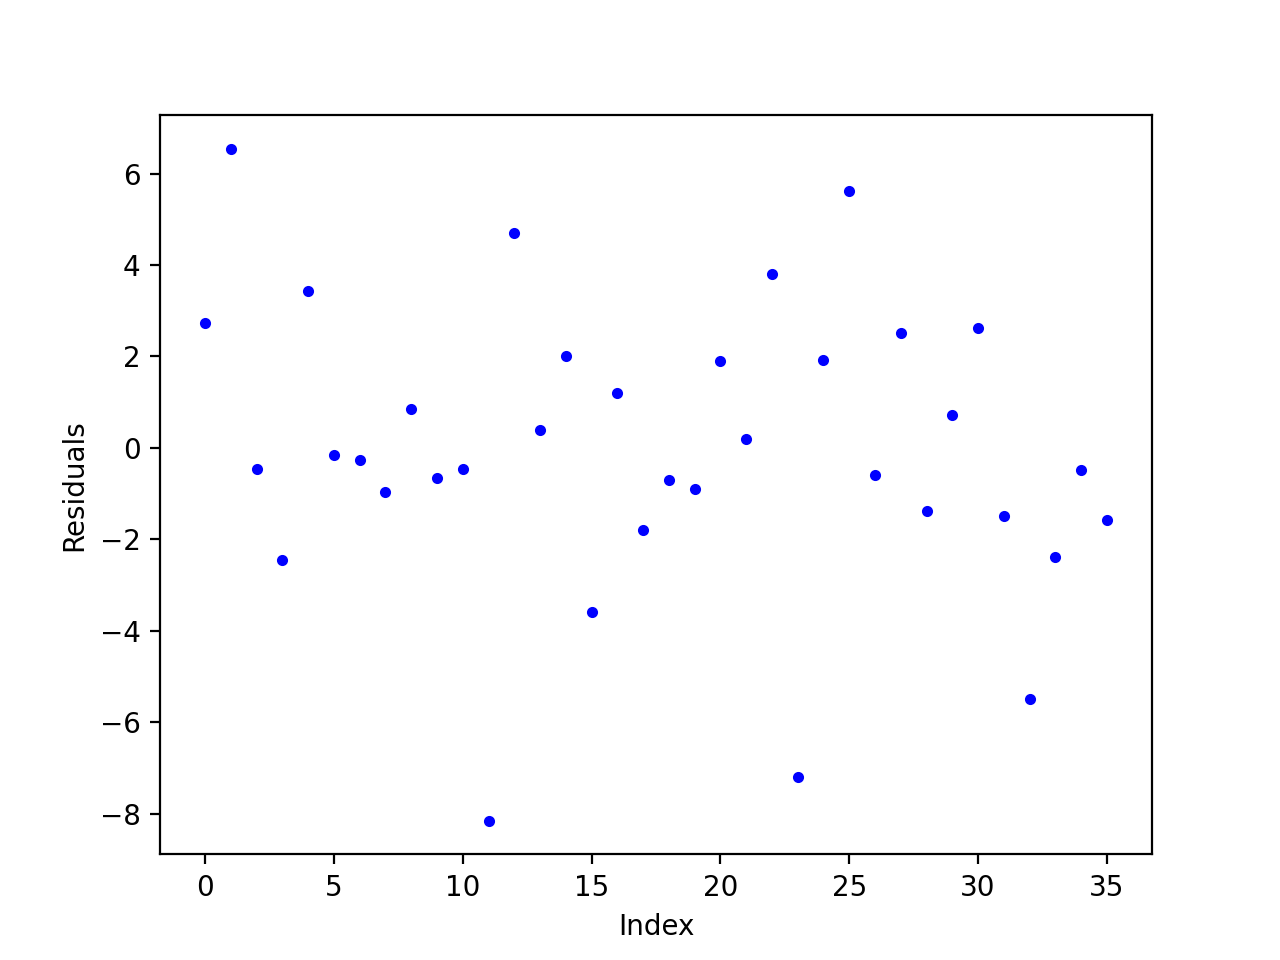

In [22]:
Res = Data3 = Data.values
list_type = ["1","2","3"]
Group3_data = [Data3[Data3[:,0] == x, 1] for x in list_type]

for i in list_type:
    group = Res[Res[:,0] == i,1]
    Res[Res[:,0] == i,1] = group - np.mean(group)
    
plt.plot(Res[:,1],marker = ".",color="blue",linestyle="none")
plt.xlabel("Index")
plt.ylabel("Residuals")

In [26]:
DW = durbin_watson(Res[:,1])
print("DW statistic is", round(DW,4))

DW statistic is 2.2991


得到DW统计量接近于2，所以可以认为数据是独立的

#### 方差齐性检验

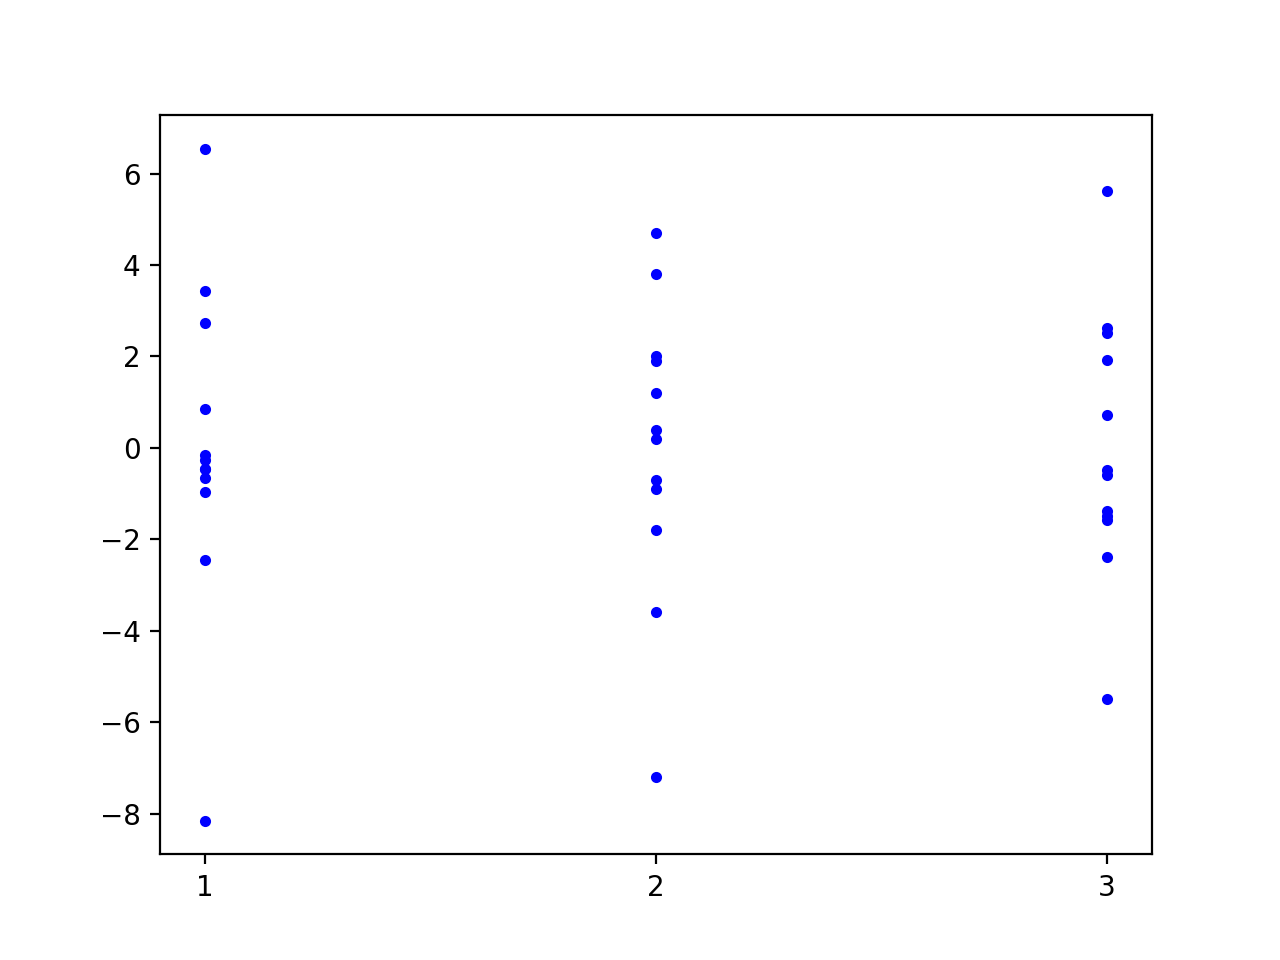

In [18]:
plt.plot(Res[:,0],Res[:,1],".",color="blue")

In [20]:
# Bartlett's Test
Bart_stat, Bart_pVal = stats.bartlett(Group3_data[0], Group3_data[1], Group3_data[2])
print("Bartlett's test statistic is", round(Bart_stat,4))
print("The p value is", round(Bart_pVal,4))

Bartlett's test statistic is 0.4247
The p value is 0.8087


In [21]:
Lev_stat, Lev_pVal = stats.levene(Group3_data[0], Group3_data[1], Group3_data[2])
print("Levene's test statistic is", round(Lev_stat,4))
print("The p value is", round(Lev_pVal,4))

Levene's test statistic is 0.0213
The p value is 0.979


得到p值均大于0.05，所以不能拒绝原假设，即满足方差齐性

#### 正态性检验

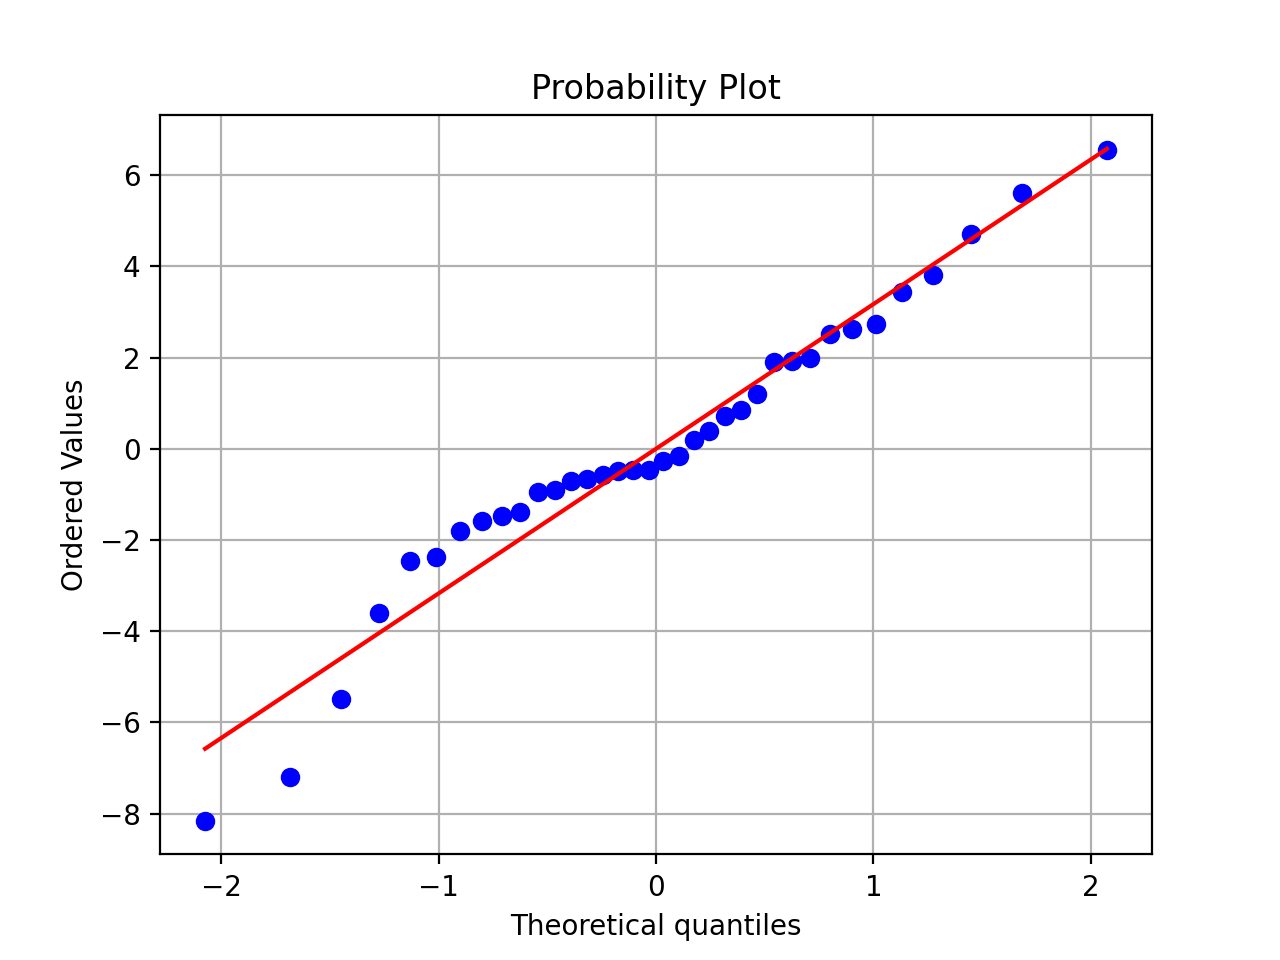

In [22]:
Res1 = Res[:,1].astype(float)
osm, osr = stats.probplot(Res1,dist= "norm",plot= plt)
plt.grid()
plt.show()

In [23]:
SW_stat,SW_pVal = stats.shapiro(Res1)
print("Shapiro-Wilk test statistic is", round(SW_stat,4))
print("The p value is", round(SW_pVal,4))

Shapiro-Wilk test statistic is 0.9625
The p value is 0.2572


得到的p值大于显著性水平，所以不能拒绝原假设，所以数据满足正态性

综上所述，此处数据满足数据独立，方差相同，服从正态分布，所以模型是合理的

### Task4: 估计食用这 3 种巧克力一小时后血浆的总抗氧能力。请分别给出点估计和区间估计

点估计

In [23]:
hat_mu = np.mean(Data.Capacity)
print("Overall Mean is:", round(hat_mu,4))

Overall Mean is: 105.6472


In [24]:
Data3 = Data.values
list_type = ["1","2","3"]
Group3_data = [Data3[Data3[:,0] == x, 1] for x in list_type]
hat_alpha = np.array([np.mean(Group3_data[i]) for i in range(a)]) - hat_mu
print("The effect of each level is", np.round(hat_alpha,4))

The effect of each level is [10.4111 -4.9472 -5.4639]


In [25]:
SSE = 0
for i in range(a):
    sub_Data = Data3[Data3[:,0] == list_type[i],1] 
    sub_sse = np.var(sub_Data) * (m) # Numpy 库中的var函数，分母上除以 m，而非（m-1）
    SSE +=  sub_sse

hat_sigma2 = SSE/(a*(m-1))
print("The estimate of sigma^2 is", round(hat_sigma2,4))

The estimate of sigma^2 is 10.4335


区间估计

In [26]:
bar_y = np.array([np.mean(Group3_data[i]) for i in range(a)])
t_right = stats.t.isf(alpha/2, n-a)
print(t_right)
left = bar_y - t_right * np.sqrt(hat_sigma2) / np.sqrt(m)
right = bar_y + t_right * np.sqrt(hat_sigma2) / np.sqrt(m)
print("left: ", left)
print("right: ", right)

2.0345152974493383
left:  [114.16125372  98.80292039  98.28625372]
right:  [117.95541295 102.59707961 102.08041295]


类型1：[114.16125372, 117.955412] 

类型2：[98.80292039, 102.59707961] 
 
类型3：[98.28625372, 102.08041295]

### Task5: 用Bonferroni方法比较吃了 3 种巧克力后，一个小时的血浆总抗氧能力两两是否存在差异

In [28]:
new_alpha = 2 * alpha / a / (a-1)
print(new_alpha)

0.016666666666666666


得到新的显著性水平为0.01666667

类型1和类型2的p值为1.7e-10

类型1和类型3的p值为3.6e-11

类型2和类型3的p值为0.68

可以发现只有类型2和类型3的比较对应的p值大于显著性水平，也即类型2和类型3之间没有差异

类型1和类型2，类型1和类型3之间有差异

### Task6 用Tukey方法比较吃了 3 种巧克力后，一个小时的血浆总抗氧能力两两是否存在差异。采用两种不同的方法来解决这个问题

#### python现有函数

In [30]:
Data["Chocolate"] = Data.Chocolate.astype(int)
Tukey= pairwise_tukeyhsd(endog = Data["Capacity"], groups=Data["Chocolate"],alpha=alpha)
print(Tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2 -15.3583    0.0 -18.5941 -12.1226   True
     1      3  -15.875    0.0 -19.1108 -12.6392   True
     2      3  -0.5167 0.9191  -3.7524   2.7191  False
------------------------------------------------------


可以看出1和2，1和3之间是有显著差异的，2和3之间无显著差异

#### 蒙特卡洛模拟

In [45]:
N = 10000
fe = n - a
nums = []
# 模拟N次
for i in range(N):
    x = np.random.randn(a)
    y = np.random.chisquare(fe, 1)
    q = (np.max(x) - np.min(x)) / np.sqrt(y)
    nums.append(q[0])
# 排序求分位数
per = np.percentile(nums, (1 - alpha) * 100)
print("分位数: ", per)
c = per * np.sqrt(hat_sigma2) / np.sqrt(m)
print("c值为: ", c)

分位数:  0.6024407116218224
c值为:  0.5617446051349895


得到对应显著性水平下分位数

In [43]:
Data3 = Data.values
list_type = [1,2,3]
Group3_data = [Data3[Data3[:,0] == x, 1] for x in list_type]
hat_alpha = np.array([np.mean(Group3_data[i]) for i in range(a)])
print(hat_alpha)

[116.05833333 100.7        100.18333333]


In [46]:
if np.abs(hat_alpha[0] - hat_alpha[1]) >= c:
    print("类型1和类型2的巧克力之间有显著差异")

if np.abs(hat_alpha[0] - hat_alpha[2]) >= c:
    print("类型1和类型3的巧克力之间有显著差异")

if np.abs(hat_alpha[1] - hat_alpha[2]) >= c:
    print("类型2和类型3的巧克力之间有显著差异")

类型1和类型2的巧克力之间有显著差异
类型1和类型3的巧克力之间有显著差异


可以得到对应的c值为0.56

且只有类型2和类型3巧克力数据均值的差值小于c值，所以类型2和类型3巧克力之间无显著差异

### Task7 基于这个例子，请评述一下Bonferroni方法和Tukey方法的异同

同：
- 水平之间两两比较
  
异：
- Bonferroni方法需要调整显著性水平，来保证联合概率不大于0.05；而Turkey方法不需要调整
- Bonferroni方法不需要构造新的分布；而Turkey方法需要构造一个极差统计量来计算
- Bonferroni方法较为简单，实现方便，但是较为保守，精度较低；而Turkey方法实现困难，需要得到新分布的分位数，但是结果较为精确